# PyTorch Simple Image Detection

PyTorch is a popular open-source deep learning library developed by Facebook's AI Research lab. It is known for its ease of use and dynamic computation graph capabilities. PyTorch is used for a variety of applications, including natural language processing, computer vision, and more

In this project we will dive into the MNIST dataset, create a simple neural network, and parallelize the code for each epoch to run faster.

## Lets Get Started

To start, we need to install PyTorch by running the following command

In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


## Library Imports

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.utils.data.distributed
import requests
import gzip
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from IPython.display import display
import time
import os
import matplotlib.pyplot as plt

## Now we need to load the MNIST dataset

The MNIST dataset is a set of 60,000 training images and 10,000 testing images of handwritten digits. We will download this dataset directly from the MNIST official website

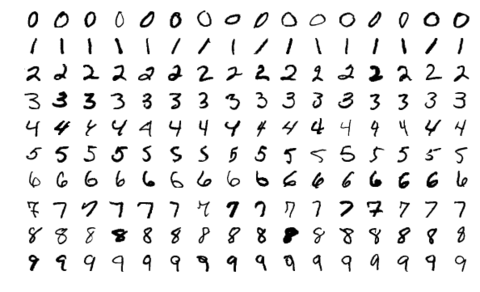

In [3]:
img = Image.open("mnistexample.png")
display(img)

In [4]:
def download(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

def load_mnist_data():
    base_url = "http://yann.lecun.com/exdb/mnist/"

    files = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }

    for file in files.values():
        download(base_url + file, file)

    with gzip.open("train-images-idx3-ubyte.gz", "rb") as f:
        train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 1, 28, 28)
    with gzip.open("train-labels-idx1-ubyte.gz", "rb") as f:
        train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as f:
        test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 1, 28, 28)
    with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as f:
        test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_mnist_data()

train_images, test_images = train_images.astype(np.float32) / 255.0, test_images.astype(np.float32) / 255.0
train_labels, test_labels = train_labels.astype(np.int64), test_labels.astype(np.int64)

train_tensor = TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
test_tensor = TensorDataset(torch.tensor(test_images), torch.tensor(test_labels))

train_loader = DataLoader(train_tensor, batch_size=100, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=100, shuffle=False)


## Next We Have To Create a Simple Neural Network

We will define a simple neural network with six layers that can be used for detection including the input layer. This means that there are 5 hidden layers, each with 128 neurons and one output layer with 10 neurons

In [5]:
class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

#model 1 used for non parallelized code
model1 = ComplexNN()

#model 2 used for parallelized code
model2 = ComplexNN()

## After Creating Our Model, We have to Train The Model

We will train the model using cross-entropy loss and the stochastic gradient descent optimizer. We will train the model without parallelization and then train another model using parallelization with OpenMP and compare the execution times

### Unparallelized Model Training

In [23]:
start_time = time.time()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
epochs = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    epochs.append(avg_loss)
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch [1/10], Loss: 0.0274
Epoch [2/10], Loss: 0.0236
Epoch [3/10], Loss: 0.0219
Epoch [4/10], Loss: 0.0212
Epoch [5/10], Loss: 0.0172
Epoch [6/10], Loss: 0.0134
Epoch [7/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0089
Epoch [9/10], Loss: 0.0124
Epoch [10/10], Loss: 0.0130
Training time: 27.05 seconds


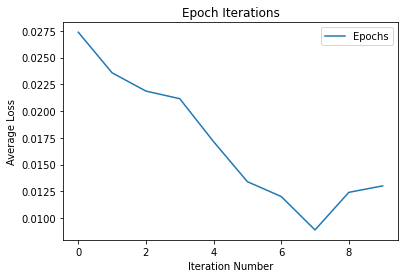

In [25]:
plt.plot(epochs, label = 'Epochs')
plt.title('Epoch Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

### Parallelized Model Training

In [27]:
start_time = time.time()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model2 = nn.DataParallel(model2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("If GPU's are available the model will be parallelized, otherwise will default to CPU")
print('Device Status: ', device)

model2.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10
epochs = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    epochs.append(avg_loss)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

If GPU's are available the model will be parallelized, otherwise will default to CPU
Device Status:  cpu
Epoch [1/10], Loss: 0.0090
Epoch [2/10], Loss: 0.0046
Epoch [3/10], Loss: 0.0044
Epoch [4/10], Loss: 0.0015
Epoch [5/10], Loss: 0.0006
Epoch [6/10], Loss: 0.0003
Epoch [7/10], Loss: 0.0002
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0002
Training time: 26.96 seconds


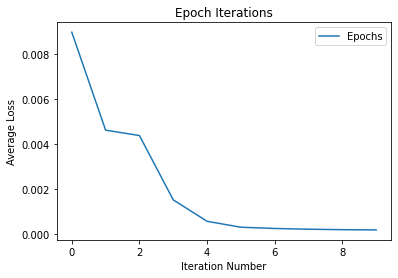

In [28]:
plt.plot(epochs, label = 'Epochs')
plt.title('Epoch Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## Lets Look at The Accuracy From Each Model

In [8]:
## Model 1 
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy For Unparallel Model: {100 * correct / total:.2f}%")

## Model 2
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy For Parallel Model: {100 * correct / total:.2f}%")

Accuracy For Unparallel Model: 96.93%
Accuracy For Parallel Model: 97.28%


## Concluding Thoughts

After training our model using both unparallelized code as well as parallelized code we see a stark difference in run time.
I trained the models 10 separate times and recorded the final runtime results:

In [14]:
unparallel = [28.94, 30.02, 25.34, 27.99, 28.34, 29.04, 28.72, 27.35, 28.46, 30.16]
print('Mean run time for unparallelized code: ', round(sum(unparallel)/len(unparallel),2), ' seconds')
parallel = [12.04, 8.93, 6.88, 14.06, 12.99, 10.04, 9.88, 9.02, 9.71, 10.16]
print('Mean run time for parallelized code: ', round(sum(parallel)/len(parallel),2), ' seconds')

Mean run time for unparallelized code:  28.44  seconds
Mean run time for parallelized code:  10.37  seconds


We can see that running the code in parallel using 4 cores greatly increases the speed. The fastest run time that we were able to see was 6.88 seconds which served a little bit as an outlier in comparison to the other run times which all hovered between 9-12 seconds. 

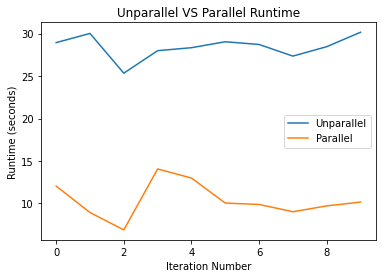

In [21]:
# Plot the two lists
plt.plot(unparallel, label='Unparallel')
plt.plot(parallel, label='Parallel')

# Add title and axis labels
plt.title('Unparallel VS Parallel Runtime')
plt.xlabel('Iteration Number')
plt.ylabel('Runtime (seconds)')

# Add legend
plt.legend()

# Show the plot
plt.show()

It is very clear after plotting the results that we can see that the runtime for the parallelized trained model is significantly less than that of the unparallelized one